In [1]:
import pickle5 as pickle
from copy import deepcopy
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

from ge import Node2Vec

from napke_utils import metapath2vec
from napke_utils import regularization
from napke_utils import BFS2vec
from napke_utils import embedding_graph

sns.set(font_scale=1.4)
# colorblind mindful color palette
colors = ['#882255', '#44AA99', '#DDCC77', '#C988EE', '#88CCEE', '#332288']
sns.set_palette(sns.color_palette(colors))

path = "path-to-data-repository"

Instructions for updating:
non-resource variables are not supported in the long term
no GPU


In [2]:
# old + bert

with open(f"{path}hin03-05.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [18]:
# grobid + bert

with open(f"{path}hin_grobid_bert-18-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [12]:
# nougat + bert

with open(f"{path}hin_nougat_bert-18-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [21]:
# old + llama

with open(f"{path}hin_old_llama3-02-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [33]:
# grobid + llama

with open(f"{path}hin_grobid_llama-18-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [30]:
# nougat + llama

with open(f"{path}hin_nougat_llama3-02-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [36]:
# old + gemma

with open(f"{path}hin_old_gemma2-13-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [ ]:
# grobid + gemma

with open(f"{path}hin_nougat_llama3-02-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [ ]:
# nougat + gemma

with open(f"{path}hin_nougat_llama3-02-09.gpickle", "rb") as fh:
    G = pickle.load(fh)

In [3]:
# node2vec
G_node = deepcopy(G)
model_node2vec = Node2Vec(G_node, walk_length = 10, num_walks = 80, p = 0.5, q = 1, workers = 1)
model_node2vec.train(window_size=5,iter=3,embed_size=512)
embeddings_node2vec = model_node2vec.get_embeddings()
G_node = embedding_graph(G_node, embeddings_node2vec)

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


Learning embedding vectors...
Learning embedding vectors done!


In [4]:
# metapath2vec
G_metapath = deepcopy(G)
embeddings_metapath2vec = metapath2vec(G_metapath, dimensions=512)
G_metapath = embedding_graph(G_metapath, embeddings_metapath2vec)

Number of random walks: 6192


In [37]:
# ephen
G_ephen = deepcopy(G)
G_ephen = regularization(G_ephen, iterations=30, mi=0.4, dim=4608)

Iteration 30 | Energy = 17061.140208992678: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


In [6]:
# bfs2vec
G_bfs = deepcopy(G)
embeddings_BFS2vec = BFS2vec(G_bfs, n_size=[4,4,4,4],  n=7, dimensions=512)
G_bfs = embedding_graph(G_bfs, embeddings_BFS2vec)

Number of random walks: 20580


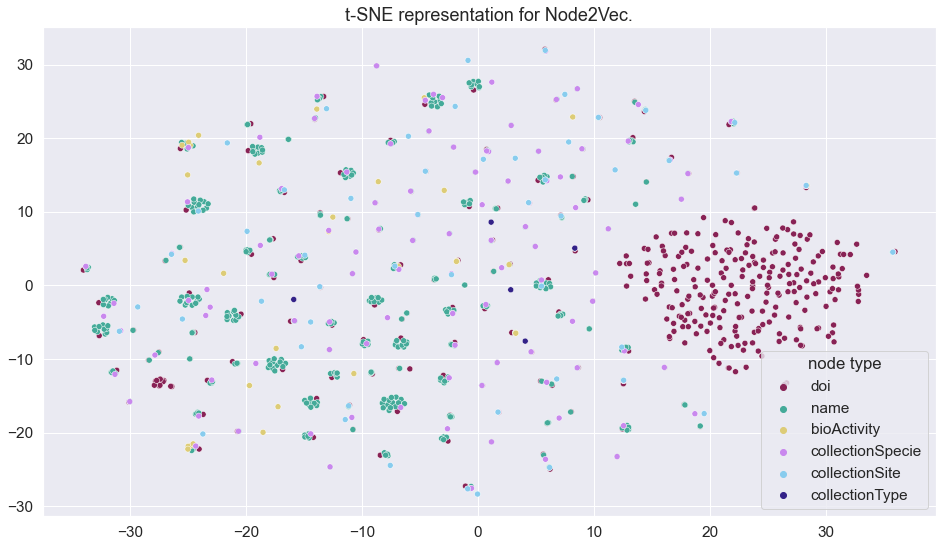

In [7]:
# node2vec
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_node.nodes() if G_node.nodes[node]['group'] in important_groups]
X = np.array([G_node.nodes[node]['f'] for node in nodes])
y = [G_node.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Node2Vec.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_node2vec.pdf", bbox_inches='tight')

In [8]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

'Average: 0.3669250645994832'

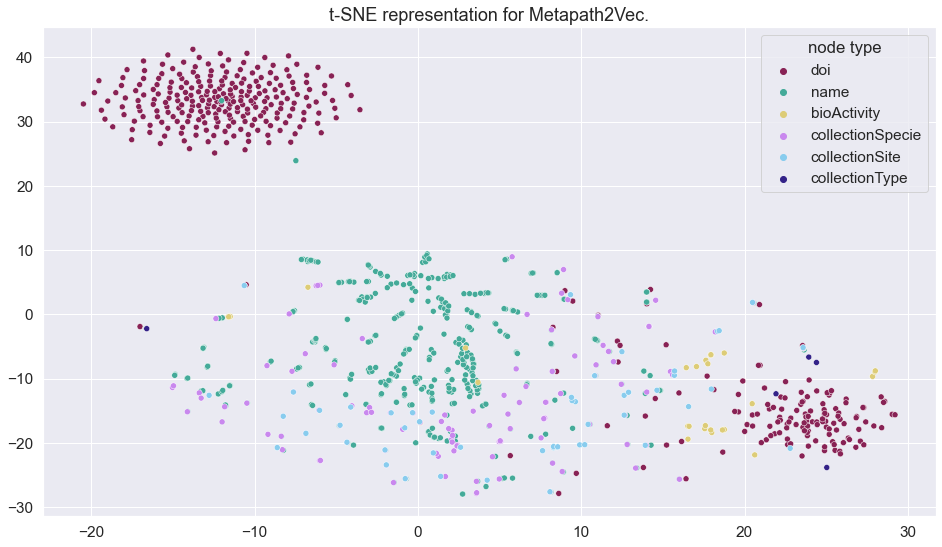

In [9]:
# metapath2vec
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_metapath.nodes() if G_metapath.nodes[node]['group'] in important_groups]
X = np.array([G_metapath.nodes[node]['f'] for node in nodes])
y = [G_metapath.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Metapath2Vec.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_metapath2vec.pdf", bbox_inches='tight')

In [10]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

'Average: 0.06718346253229975'

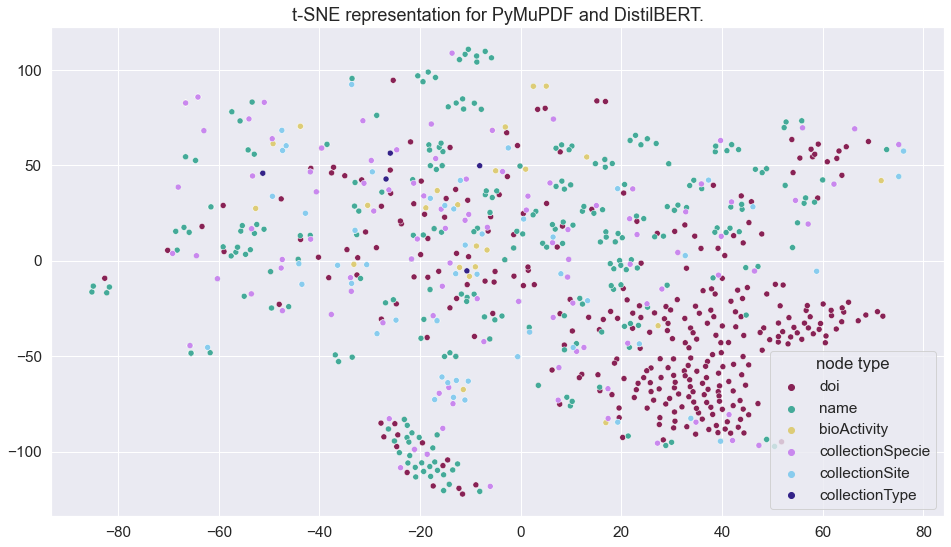

In [10]:
# ephen
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=30.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for PyMuPDF and DistilBERT.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_old_bert.pdf", bbox_inches='tight')

In [11]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/var/folders/_q/9djqcd1n39x3jty15jbvy2sm0000gn/T/ipykernel_38050/456637756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]


'Average: 0.3643410852713178'

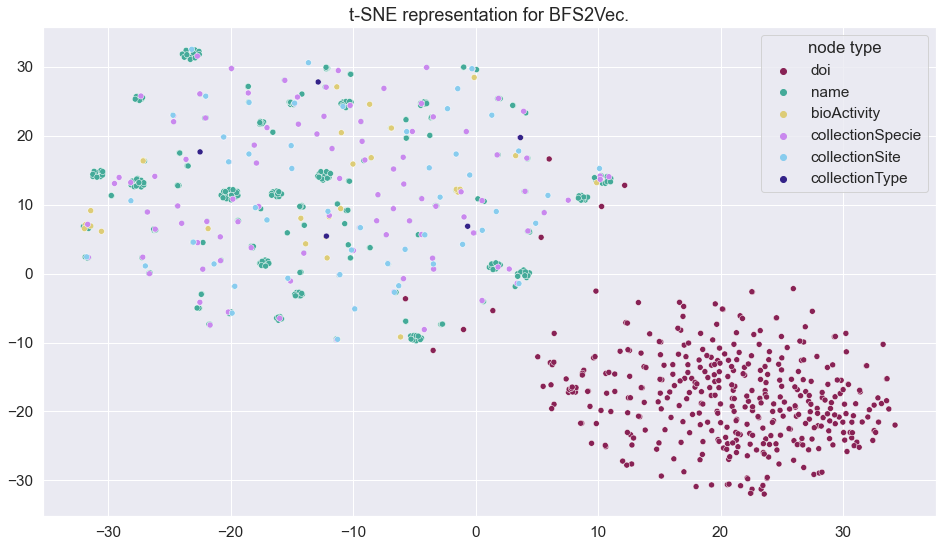

In [13]:
# BFS2Vec
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_bfs.nodes() if G_bfs.nodes[node]['group'] in important_groups]
X = np.array([G_bfs.nodes[node]['f'] for node in nodes])
y = [G_bfs.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for BFS2Vec.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_bfs.pdf", bbox_inches='tight')

In [14]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

'Average: 0.020671834625323'

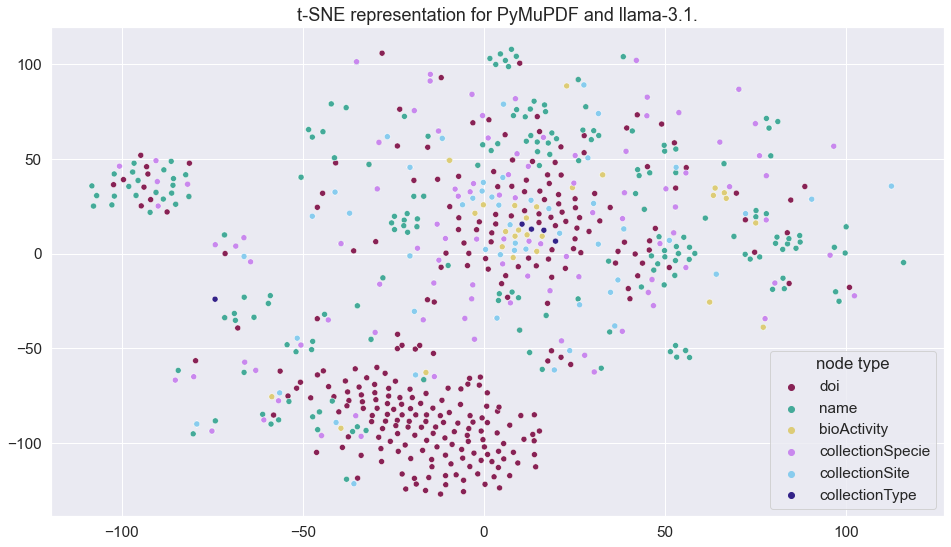

In [24]:
# old + llama
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for PyMuPDF and llama-3.1.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_old_llama.pdf", bbox_inches='tight')

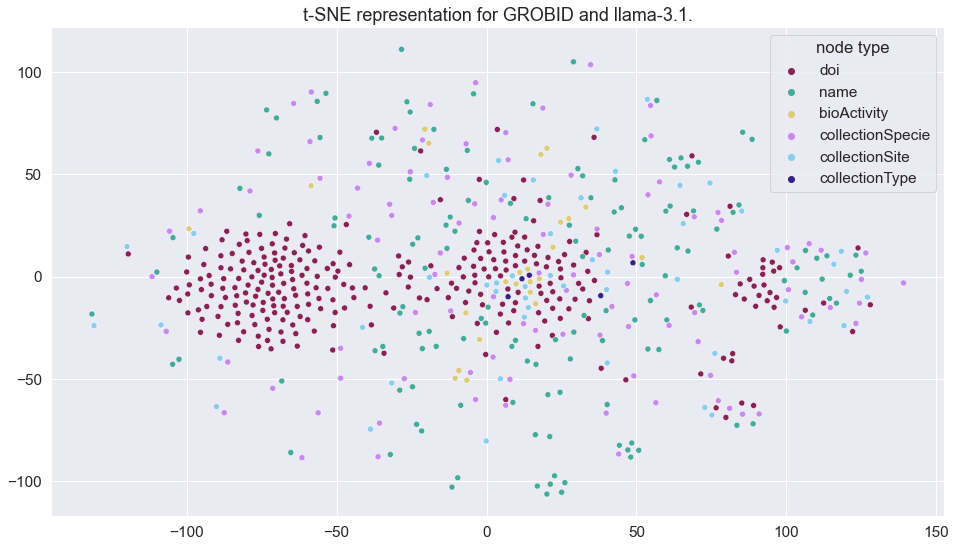

In [35]:
# grobid + llama
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for GROBID and llama-3.1.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_grobid_llama.pdf", bbox_inches='tight')

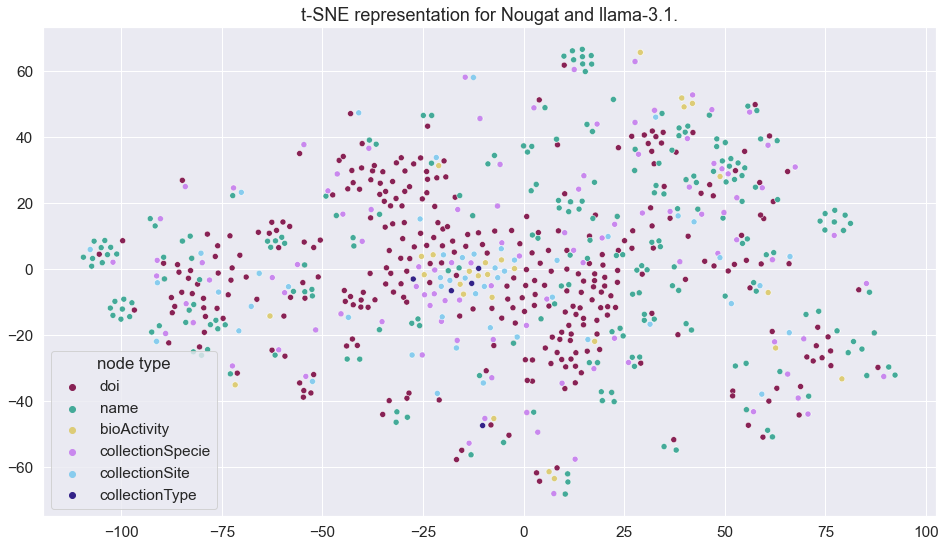

In [32]:
# nougat + llama
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Nougat and llama-3.1.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_nougat_llama.pdf", bbox_inches='tight')

In [6]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/var/folders/_q/9djqcd1n39x3jty15jbvy2sm0000gn/T/ipykernel_50366/456637756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]


'Average: 0.3669250645994832'

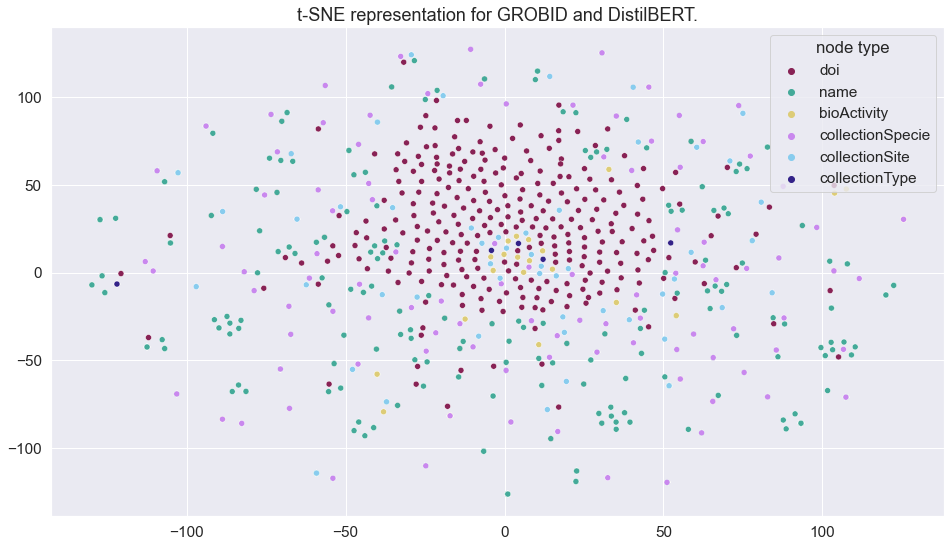

In [20]:
# grobid + bert
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for GROBID and DistilBERT.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_grobid_bert.pdf", bbox_inches='tight')

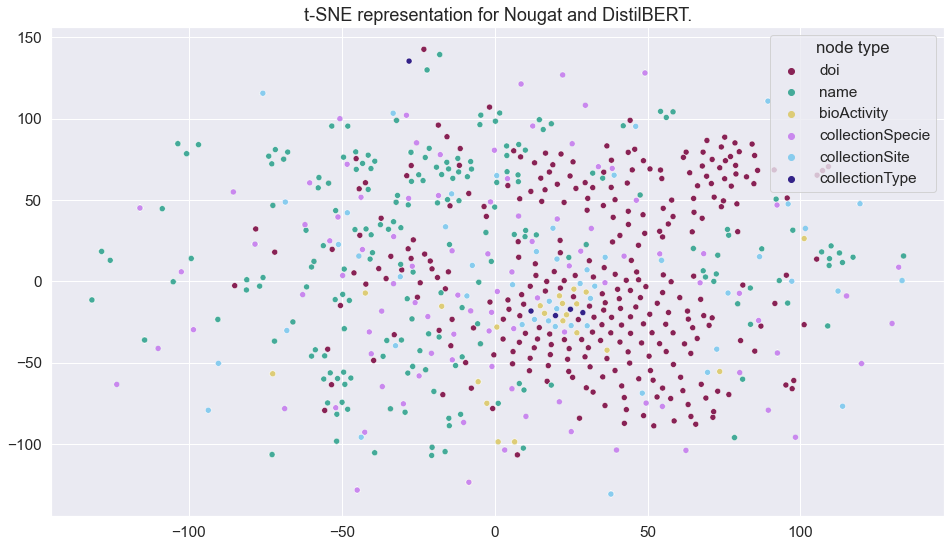

In [17]:
# nougat + bert
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Nougat and DistilBERT.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_nougat_bert.pdf", bbox_inches='tight')

In [16]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/var/folders/_q/9djqcd1n39x3jty15jbvy2sm0000gn/T/ipykernel_38050/456637756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]


'Average: 0.3669250645994832'

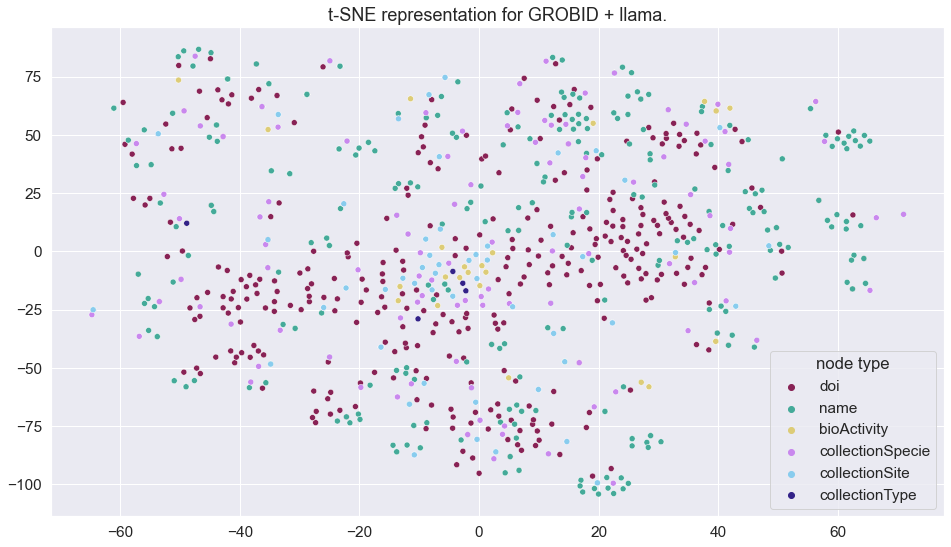

In [11]:
# grobid + llama
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for GROBID + llama.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_grobid_llama.pdf", bbox_inches='tight')

In [12]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'doi'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/var/folders/_q/9djqcd1n39x3jty15jbvy2sm0000gn/T/ipykernel_50366/456637756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]


'Average: 0.3669250645994832'

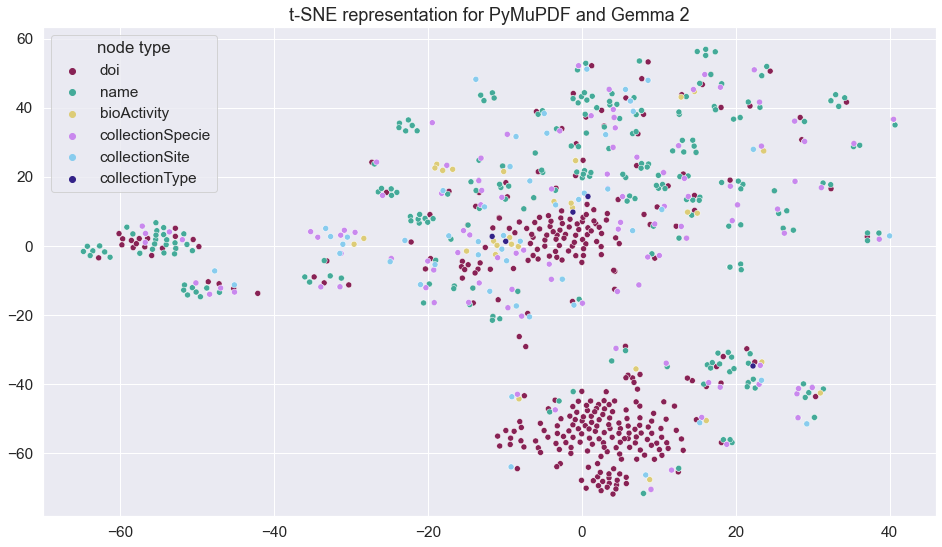

In [38]:
# old + gemma
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for PyMuPDF and Gemma 2')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_old_gemma.pdf", bbox_inches='tight')

In [ ]:
# grobid + gemma
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for GROBID and Gemma 2')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_grobid_gemma.pdf", bbox_inches='tight')

In [ ]:
# nougat + gemma
important_groups = ['bioActivity', 'collectionSpecie', 'collectionSite', 'collectionType', 'name', 'doi']

nodes = [node for node in G_ephen.nodes() if G_ephen.nodes[node]['group'] in important_groups]
X = np.array([G_ephen.nodes[node]['f'] for node in nodes])
y = [G_ephen.nodes[node]['group'] for node in nodes]

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0, init='random', learning_rate='auto').fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
t = pd.CategoricalDtype(categories=['doi', 'name','bioActivity','collectionSpecie','collectionSite','collectionType'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Nougat and Gemma 2')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(16,9)
g.get_figure().savefig(f"{path}tsne/tsne_nougat_gemma.pdf", bbox_inches='tight')